#sp_deli
script modified for the NMNH workshop, derived from:

Derkarabetian S., Castillo S., Peter K.K., Ovchinnikov S., Hedin M.

A Demonstration of Unsupervised Machine Learning in Species Delimitation

https://doi.org/10.1016/j.ympev.2019.106562

https://github.com/sokrypton/sp_deli
 

Load needed libraries

In [1]:
# note this code was written using tensorflow v1
# by using compat.v1 function it should run in both tensorflow 1 and 2
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow.compat.v1.keras as keras
from tensorflow.compat.v1.keras.layers import *
from tensorflow.compat.v1.keras.models import Sequential, Model
from tensorflow.compat.v1.keras.metrics import categorical_crossentropy
import tensorflow.compat.v1.keras.backend as K

import numpy as np
import matplotlib.pylab as plt

import seaborn as sns

plt.style.use('seaborn-colorblind')


Functions to save and load datasets. The script expects data in "one-hot" format. 

Column 1 is sample name

Column 2 is group (a priori groups, morphospecies, etc)

Columns 3–n are one-hot encoded data.

In [2]:
def save_data(filename,tmp):
  fo = open(filename, "w")
  for n in range(tmp["shape"][0]):
    print(tmp["name"][n],tmp["group"][n],end="",file=fo)
    for i in range(tmp["shape"][1]):
      print("",end=" ",file=fo)
      print(",".join([str(i) for i in list(tmp["one_hot"][n][i])]),end="",file=fo)
    print("",file=fo)
  fo.close()
    
def load_data(filename):
  tmp = {
      "data_set":filename.replace(".txt",""),
      "name":[],
      "group":[],
      "one_hot":[]
  }
  file = open(filename,"r")
  for line in file:
    val = line.rstrip("\n").split(" ")
    tmp["name"].append(val[0])
    tmp["group"].append(val[1])
    tmp["one_hot"].append([])
    
    for n in range(2,len(val)):
      tmp["one_hot"][-1].append(val[n].split(","))
      
  tmp["name"] = np.array(tmp["name"],np.str)
  tmp["group"] = np.array(tmp["group"],np.str)
  tmp["one_hot"] = np.array(tmp["one_hot"],np.float)
  tmp["shape"] = tmp["one_hot"].shape
  return tmp

Functions for plot generation

In [3]:
def gen_color_map(groups,mode="hls"):
  uni_groups = np.unique(groups)
  color_map = {}
  for i,c in enumerate(sns.color_palette(mode,len(uni_groups))):
    color_map[uni_groups[i]] = [c]
  return(color_map)


def plot_z(z,loc,title="none",legend=True,color_map=None):
  
  if color_map is None:
    color_map = gen_color_map(loc)
  
  x = z[:,0]
  y = z[:,1]

  for lo in np.unique(loc):
    color = color_map[lo]
    xx = []
    yy = []
    for i in range(z.shape[0]):
      if lo == loc[i]:
        xx.append(x[i])
        yy.append(y[i])
    plt.scatter(xx,yy,c=color,label=lo)

  if title != "none": plt.title(title)
  if legend == True:
    plt.legend(bbox_to_anchor=(1, 0, 0.5, 1),loc="upper left",)
  
def plot_mu_sg(mu,sg,loc,sample=100,alpha=0.5,title="none",legend=True,color_map=None):
  
  if color_map is None:
    color_map = gen_color_map(loc)
  
  for lo in np.unique(loc):
    color = color_map[lo]
    xx = []
    yy = []
    for i in range(len(loc)):
      if lo == loc[i]:
        x,y = (mu[i] + np.random.normal(0,1,size=(sample,2)) * sg[i]).T
        
        xx += list(x)
        yy += list(y)
    plt.scatter(xx,yy,s=40,c=color,label=lo,alpha=alpha,linewidths=0)

  plt.scatter(mu[:,0],mu[:,1],s=40,facecolors='none',edgecolors='black',linewidths=2)
  if title != "none": plt.title(title)
  if legend == True:
    plt.legend(bbox_to_anchor=(1, 0, 0.5, 1),loc="upper left")
  
    

Function to make VAE model

In [4]:
def mk_model(
    original_dim,    # number of snps
    cat,             # number of categories of one-hot-encoding
    latent_dim=2,    # dimensionality of latent space, 2D representation
    
    # encoder
    en_dim= [100,100,100],    # number of neurons for each layer
    en_drop=[0.5,0.5,0.5],    # rate of dropout for each layer
    
    # decoder
    de_dim= [100,100,100],  # number of neurons for each layer
    de_drop=[0.5,0.5,0.5],  # rate of dropout for each layer
    
    act = "elu" # activation function for each layer
):
  
  def act_fn(fn,tensor):
    if fn == "leakyrelu": return LeakyReLU()(tensor)
    else: return Activation(fn)(tensor)
  
  half_cat = int(cat/2)
  ########################################################################
  # INPUT
  ########################################################################  
  x_in = Input(shape=(original_dim,cat),name="x_in")
  x_in_em = Dense(half_cat,use_bias=False,name="x_in_em")(x_in)
    
  ########################################################################
  # ENCODER :: Q(z|X)
  ########################################################################
  en = Flatten()(x_in_em)
  en = BatchNormalization(scale=False,center=False)(en)
  
  for i in range(len(en_dim)):
    en = Dense(en_dim[i])(en)
    en = Dropout(en_drop[i])(en)
    en = act_fn(act,en)
    en = BatchNormalization(scale=False,center=False)(en)
    
  ########################################################################
  # Z (Latent space)
  ########################################################################  
  Z_mu = Dense(latent_dim)(en)  
  Z_log_sigma_sq = Dense(latent_dim)(en)
  
  Z_sigma = Lambda(lambda x: K.exp(0.5*x))(Z_log_sigma_sq)
  
  Z = Lambda(lambda x: x[0]+x[1]*K.random_normal(K.shape(x[0])))([Z_mu,Z_sigma])
  
  ########################################################################
  # DECODER :: P(X|z)
  ########################################################################
  de = Z
  for i in range(len(de_dim)):
    de = Dense(de_dim[i])(de)
    de = Dropout(de_drop[i])(de)
    de = act_fn(act,de)
    de = BatchNormalization(scale=False,center=False)(de)
  
  de = Dense(original_dim*half_cat)(de)
  ########################################################################
  # OUTPUT
  ########################################################################  
  x_out_em = Reshape((-1,half_cat))(de)
  x_out = Dense(cat,activation="softmax")(x_out_em)
  ########################################################################
  
  # Compute the loss
  def vae_loss(kl_weight=0.5):
    def loss(x_true, x_pred):
      # mask out missing data!
      mask = K.sum(x_in,axis=-1)

      # sigma (or standard deviation), keeping close to 1
      # mu (or mean), keeping close to 0
      kl_loss = K.sum(K.square(Z_mu) + K.square(Z_sigma) - Z_log_sigma_sq - 1.0, axis=-1)

      # reconstruction (categorical crossentropy)
      recon = K.sum(keras.metrics.categorical_crossentropy(x_in,x_out) * mask, axis=-1)
      
      return K.mean(recon + kl_loss * kl_weight)
    return loss

  # Compute accuracy  
  def acc(x_true,x_pred):
    mask = K.sum(x_in,axis=-1,keepdims=True)
    acc = K.sum(K.square(x_in-x_out),axis=-1,keepdims=True)
    return K.mean(1.0 - K.sqrt(K.sum(acc*mask,axis=1)/K.sum(mask,axis=1)))
    
  vae0 = Model([x_in],[x_out],name="vae0")
  vae0.compile(optimizer='adam', loss=vae_loss(0.1), metrics=[acc])
  
  vae1 = Model([x_in],[x_out],name="vae1")
  vae1.compile(optimizer='adam', loss=vae_loss(0.5), metrics=[acc])
  
  enc = Model([x_in],[Z_mu,Z_sigma],name="enc")
  return vae0,vae1,enc

function to generate models, train, and plot the latent space (Z)

In [5]:
def do_it(data):
  plt.rcParams['figure.figsize'] = [10, 10]
  plt.style.use('seaborn-colorblind')

  def gen(batch_size):
    while True:
      idx = np.random.randint(0,data["shape"][0],size=batch_size)
      tmp = data["one_hot"][idx]
      yield tmp,tmp

  K.clear_session()
  vae0,vae1,enc = mk_model(data["shape"][1],data["shape"][2])
  loss_history = []
  acc_history = []
  
  
  # we do different batch_sizes: 1/4, 1/3, 1/2 and 1/1 of the data
  # (similar to changing the temperature)
  r = 4
  for i in range(r):
    f = 1/(r-i)
    batch_size = int(data["shape"][0] * f + 0.5)
    steps = int(data["shape"][0]/batch_size + 0.5)
    epochs = int(1000 * f + 0.5)     # number of generations

    for vae in (vae0,vae1):
      print("-")
      his = vae.fit_generator(
          gen(batch_size),
          steps_per_epoch=steps,
          epochs=epochs,
          verbose=False
      )
      loss_history += list(his.history['loss'])
      acc_history += list(his.history['acc'])
      
      # calculate average loss after 50% burnin
      loss_postburn = loss_history[len(loss_history)//2:]
      loss_postburn_avg = sum(loss_postburn)/len(loss_postburn)

    if i == r-1:
      # plot loss and accuracy
      plt.figure(figsize=(20,10))
      plt.subplot(1, 2, 1)
      plt.plot(np.arange(len(loss_history)),loss_history)
      plt.ylabel("loss")
      plt.figtext(0,0,loss_postburn_avg)
      plt.subplot(1, 2, 2)
      plt.plot(np.arange(len(acc_history)),acc_history)
      plt.ylabel("accuracy")
      plt.show()
      
      vae_mu,vae_sg = enc.predict(data["one_hot"])

      
  return(vae_mu,vae_sg)




Import dataset. We will use the one from the publication, available at the provided github link below. No need to manually download.

In [6]:
!wget -qc https://github.com/sokrypton/sp_deli/raw/master/data/Metano_UCE_SNPs_70percent.txt
!ls

Metano_UCE_SNPs_70percent.txt  sample_data


Instructions for updating:
Colocations handled automatically by placer.
-


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


-
-
-
-
-
-
-


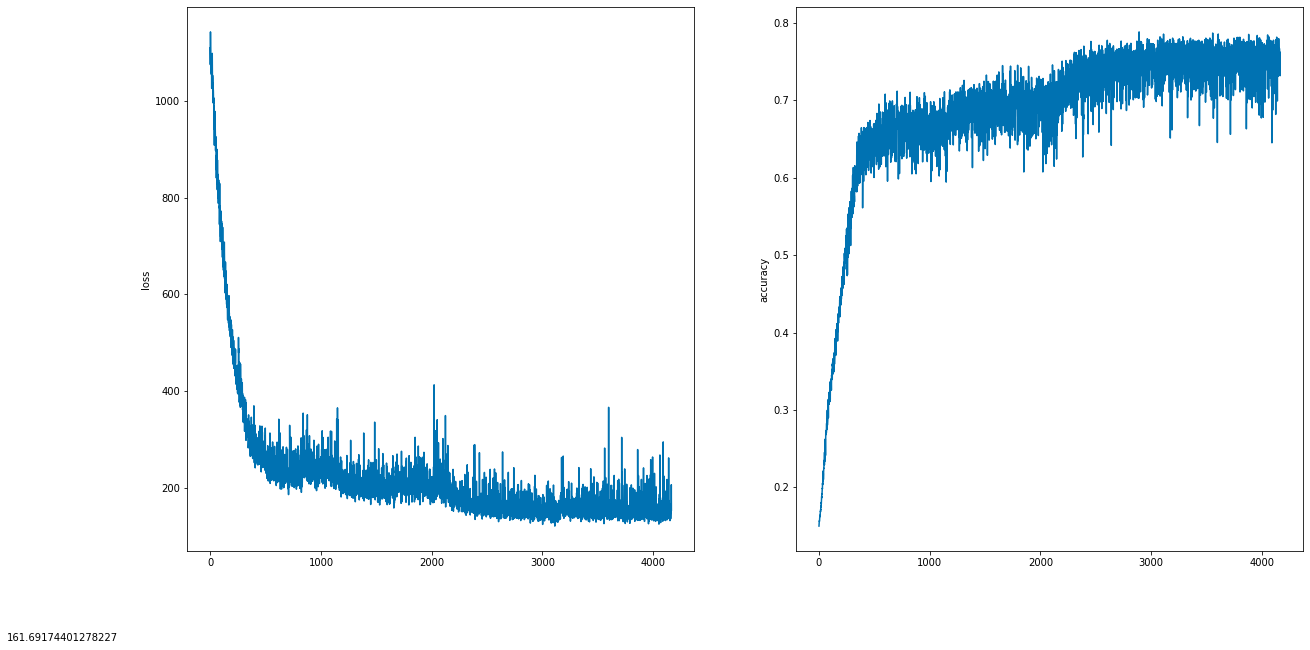

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


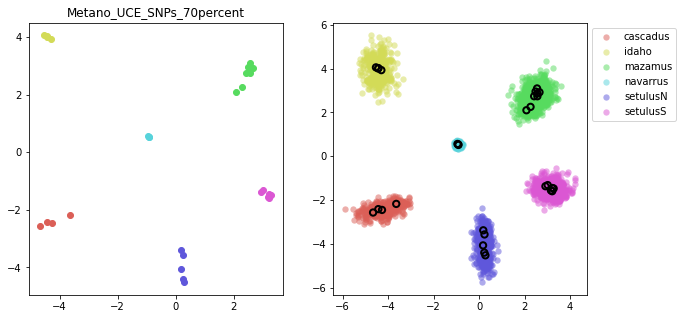

In [7]:
data_sets = [
  "Metano_UCE_SNPs_70percent.txt"
]

for data_set in data_sets:
  # load data
  data = load_data(data_set)
  
  # get mu and sigma
  vae_mu,vae_sg = do_it(data)
  
  # plot results!
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.title(data["data_set"])
  plot_z(vae_mu,data["group"],legend=False)
  plt.subplot(1, 2, 2)
  plot_mu_sg(vae_mu,vae_sg,data["group"],sample=100)
  plt.show()


Create output files

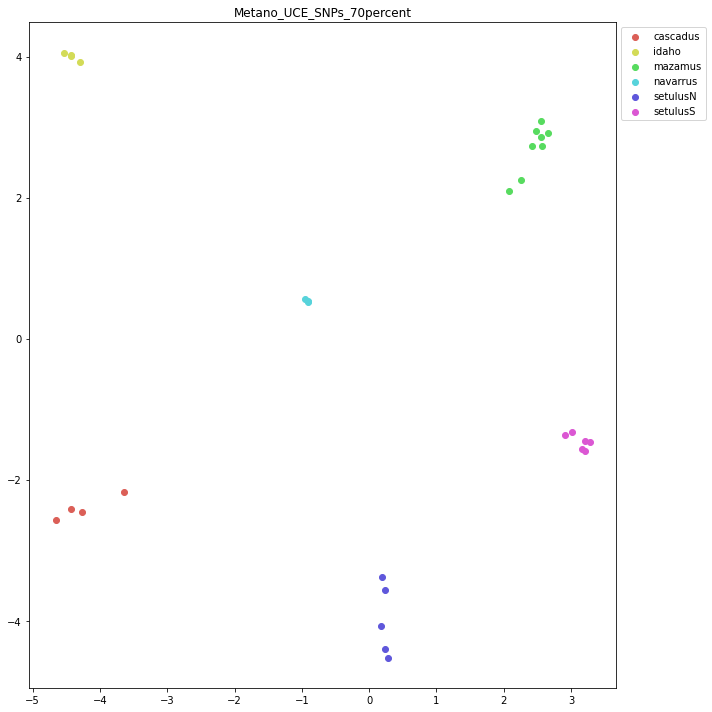

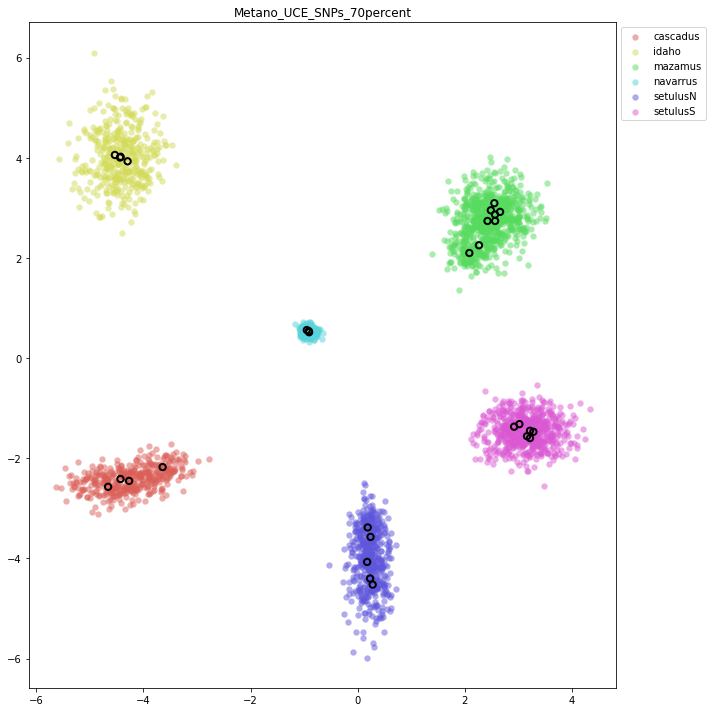

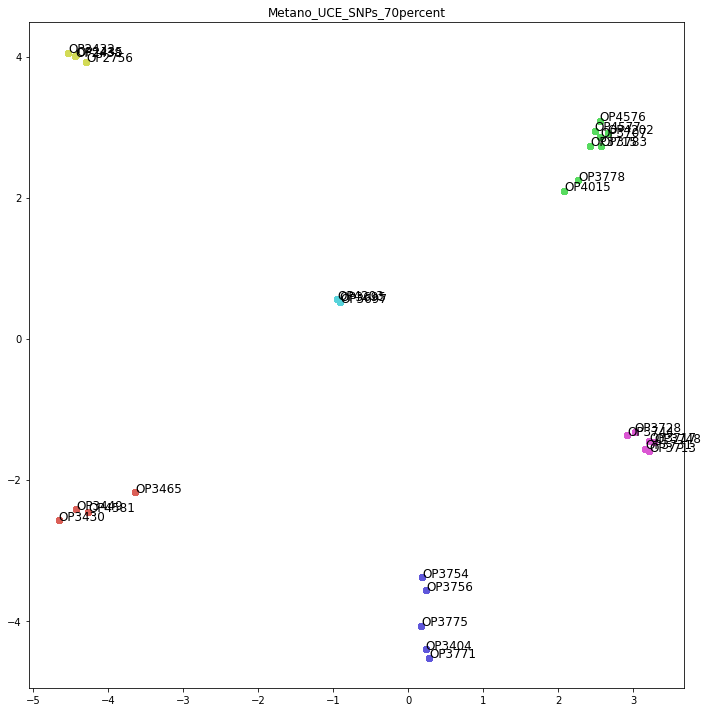

In [8]:
# scatterplot
vae_mu
np.savetxt("vae_mu.csv", vae_mu, delimiter=",")

# make pdfs of plots
# plot with mean only
f=plt.figure()
plt.title(data["data_set"])
plot_z(vae_mu,data["group"],legend=True)
plt.tight_layout()
f.savefig("vae_mu.pdf")

# plot with mean and standard deviation
f=plt.figure()
plt.title(data["data_set"])
plot_mu_sg(vae_mu,vae_sg,data["group"],sample=100)
plt.tight_layout()
f.savefig("vae_mu_sg.pdf")

# plot with sample labels
f=plt.figure()
plt.title(data["data_set"])
for i in range(len(vae_mu)):
    x = vae_mu[i][0]
    y = vae_mu[i][1]
    plot_z(vae_mu,data["group"],legend=False)
    plt.text(x,y,(data["name"][i]),fontsize=12)
plt.tight_layout()
f.savefig("vae_mu_labels.pdf")